#### Imports & Downloads

In [155]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn import metrics

from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgboost
from sklearn.svm import LinearSVC

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import cross_val_score
import vectorize_functions

from sklearn.metrics import mean_squared_error
import time
import optuna

from optuna.visualization.matplotlib import plot_optimization_history
from optuna.visualization.matplotlib import plot_param_importances
from typing import Tuple
from sklearn.metrics import log_loss
from optuna.samplers import TPESampler

### Einladen der vektorisierten Daten - BOW

In [90]:
X_train, X_test, y_train, y_test = vectorize_functions.vectorize_bow()

In [91]:
positive = np.count_nonzero(y_train == 1)
negative = np.count_nonzero(y_train == 0)
print("Train")
print("- Positive:", positive)
print("- Negative:", negative)
print("- Verhältnis:", negative / positive)

positive = np.count_nonzero(y_test == 1)
negative = np.count_nonzero(y_test == 0)
print("Test")
print("- Positive:", positive)
print("- Negative:", negative)
print("- Verhältnis:", negative / positive)

Train
- Positive: 1270
- Negative: 18084
- Verhältnis: 14.239370078740157
Test
- Positive: 541
- Negative: 7754
- Verhältnis: 14.33271719038817


In [92]:
print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)

print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

X_train shape (19354, 6293)
y_train shape (19354,)
X_test shape (8295, 6293)
y_test shape (8295,)


### 2. Ensemble Models

In [162]:
evaluation = pd.DataFrame(
    columns=["model", "variant", "train_acc", "train_prec", "train_rec", "train_f1", "test_acc", "test_prec",
             "test_rec", "test_f1"])

In [94]:
def add_to_eval_df(model, model_name, variant, x_data_train, y_data_train, x_data_test, y_data_test):
    train_acc = model.score(x_data_train, y_data_train)
    train_precision = precision_score(y_data_train, model.predict(x_data_train))
    train_recall = recall_score(y_data_train, model.predict(x_data_train))
    train_f1 = f1_score(y_data_train, model.predict(x_data_train))

    test_acc = model.score(x_data_test, y_data_test)
    test_precision = precision_score(y_data_test, model.predict(x_data_test))
    test_recall = recall_score(y_data_test, model.predict(x_data_test))
    test_f1 = f1_score(y_data_test, model.predict(x_data_test))

    evaluation.loc[len(evaluation.index)] = [model_name, variant, train_acc, train_precision, train_recall, train_f1,
                                             test_acc, test_precision, test_recall, test_f1]

In [95]:
def evaluate_model(model, x_test, y_test, sampling_method):
    pred = model.predict(x_test)
    accscore = metrics.accuracy_score(pred, y_test)

    print(f'{sampling_method} model accuracy for classification is =', str('{:04.2f}'.format(accscore * 100)) + '%')
    print('------------------------------------------------')
    print('Confusion Matrix:')
    print(pd.DataFrame(confusion_matrix(y_test, pred)))
    print('------------------------------------------------')
    print('Classification Report:')
    print(classification_report(y_test, pred))

    probs = model.predict_proba(x_test)
    preds = probs[:, 1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


#### 2.1 Bagging

##### 2.1.1 RandomForest

###### RandomForest no tuning

In [96]:
rf = RandomForestClassifier(n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1)

none model accuracy for classification is = 95.53%
------------------------------------------------
Confusion Matrix:
      0    1
0  7675   79
1   292  249
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      7754
           1       0.76      0.46      0.57       541

    accuracy                           0.96      8295
   macro avg       0.86      0.73      0.77      8295
weighted avg       0.95      0.96      0.95      8295



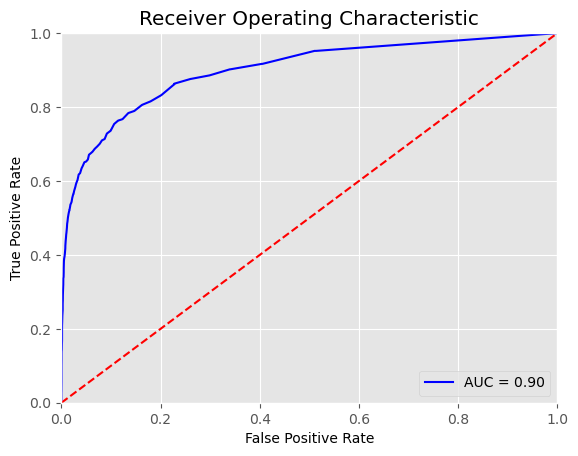

In [163]:
evaluate_model(rf, X_test, y_test, "none")
add_to_eval_df(rf, "RandomForestClassifier", "clean", X_train, y_train, X_test, y_test)

In [98]:
cv = cross_val_score(rf, X_train, y_train, cv=10, scoring='f1', verbose=10)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] START .....................................................................
[CV] END ................................ score: (test=0.470) total time=  18.8s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.8s remaining:    0.0s


[CV] END ................................ score: (test=0.582) total time=   3.2s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   22.0s remaining:    0.0s


[CV] END ................................ score: (test=0.528) total time=   3.1s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   25.2s remaining:    0.0s


[CV] END ................................ score: (test=0.548) total time=   3.0s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   28.3s remaining:    0.0s


[CV] END ................................ score: (test=0.511) total time=   3.0s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   31.4s remaining:    0.0s


[CV] END ................................ score: (test=0.457) total time=   3.0s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   34.5s remaining:    0.0s


[CV] END ................................ score: (test=0.531) total time=   2.9s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   37.5s remaining:    0.0s


[CV] END ................................ score: (test=0.567) total time=   3.0s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   40.6s remaining:    0.0s


[CV] END ................................ score: (test=0.554) total time=   3.0s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   43.7s remaining:    0.0s


[CV] END ................................ score: (test=0.524) total time=   3.0s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   46.8s finished


In [99]:
np.mean(cv)

0.5273134419981311

###### RandomForest tuning (GridSearchCV)

In [100]:
# todo

###### RandomForest tuning (RandomizedSearchCV)

In [101]:
param_grid = {
    'n_estimators': [100, 150, 200, 250],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [3, 6, 9],
    'max_leaf_nodes': [9, 11, 13],
}

In [102]:
random_search = RandomizedSearchCV(RandomForestClassifier(n_jobs=-1),
                                   param_grid,
                                   scoring='f1',
                                   verbose=10)
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START max_depth=3, max_features=None, max_leaf_nodes=11, n_estimators=150
[CV 1/5; 1/10] END max_depth=3, max_features=None, max_leaf_nodes=11, n_estimators=150;, score=0.220 total time=   2.2s
[CV 2/5; 1/10] START max_depth=3, max_features=None, max_leaf_nodes=11, n_estimators=150
[CV 2/5; 1/10] END max_depth=3, max_features=None, max_leaf_nodes=11, n_estimators=150;, score=0.189 total time=   1.5s
[CV 3/5; 1/10] START max_depth=3, max_features=None, max_leaf_nodes=11, n_estimators=150
[CV 3/5; 1/10] END max_depth=3, max_features=None, max_leaf_nodes=11, n_estimators=150;, score=0.148 total time=   1.4s
[CV 4/5; 1/10] START max_depth=3, max_features=None, max_leaf_nodes=11, n_estimators=150
[CV 4/5; 1/10] END max_depth=3, max_features=None, max_leaf_nodes=11, n_estimators=150;, score=0.236 total time=   1.5s
[CV 5/5; 1/10] START max_depth=3, max_features=None, max_leaf_nodes=11, n_estimators=150
[CV 5/5; 1/10]

RandomizedSearchCV(estimator=RandomForestClassifier(n_jobs=-1),
                   param_distributions={'max_depth': [3, 6, 9],
                                        'max_features': ['sqrt', 'log2', None],
                                        'max_leaf_nodes': [9, 11, 13],
                                        'n_estimators': [100, 150, 200, 250]},
                   scoring='f1', verbose=10)

In [103]:
print(random_search.best_estimator_)

RandomForestClassifier(max_depth=3, max_features=None, max_leaf_nodes=11,
                       n_estimators=150, n_jobs=-1)


In [104]:
rf_tuned = RandomForestClassifier(**random_search.best_params_)
rf_tuned.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, max_features=None, max_leaf_nodes=11,
                       n_estimators=150)

none model accuracy for classification is = 94.02%
------------------------------------------------
Confusion Matrix:
      0   1
0  7734  20
1   476  65
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      7754
           1       0.76      0.12      0.21       541

    accuracy                           0.94      8295
   macro avg       0.85      0.56      0.59      8295
weighted avg       0.93      0.94      0.92      8295



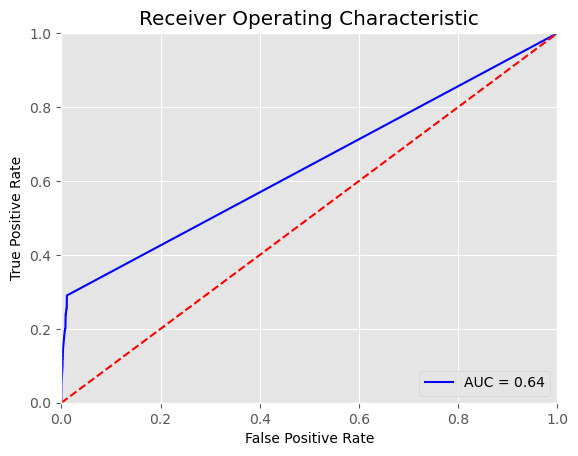

In [164]:
evaluate_model(rf_tuned, X_test, y_test, "none")
add_to_eval_df(rf_tuned, "RandomForestClassifier-tuned-rand", "clean", X_train, y_train, X_test, y_test)

###### RandomForest tuning (optuna)
https://gist.github.com/shamilnabiyev/c1b6e23444a949bc45243eab445a3806

In [106]:
def objective_rf(trial):
    n_estimators = trial.suggest_int(name="n_estimators", low=100, high=500, step=50)
    max_depth = trial.suggest_int(name="max_depth", low=10, high=150, step=5)
    min_samples_split = trial.suggest_int(name="min_samples_split", low=2, high=10, step=2)
    min_samples_leaf = trial.suggest_int(name="min_samples_leaf", low=1, high=4, step=1)

    params = {
        "n_estimators": n_estimators,
        "max_depth": max_depth,
        "min_samples_split": min_samples_split,
        "min_samples_leaf": min_samples_leaf
    }
    model = RandomForestClassifier(random_state=42, **params)

    cv_score = cross_val_score(model, X_train, y_train, n_jobs=-1, cv=5, scoring='f1')
    mean_cv_accuracy = cv_score.mean()
    return mean_cv_accuracy

In [107]:
sampler = TPESampler(seed=42)
pruner = optuna.pruners.MedianPruner(n_warmup_steps=10)
study_rf = optuna.create_study(sampler=sampler, pruner=pruner, direction="maximize")
study_rf.optimize(objective_rf, n_trials=50)

[I 2024-11-24 17:05:46,817] A new study created in memory with name: no-name-8dee8445-aca1-4a8f-95fc-1b10200a7399
[I 2024-11-24 17:06:07,893] Trial 0 finished with value: 0.29609753544146195 and parameters: {'n_estimators': 250, 'max_depth': 145, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.29609753544146195.
[I 2024-11-24 17:06:12,406] Trial 1 finished with value: 0.04593400423643006 and parameters: {'n_estimators': 150, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.29609753544146195.
[I 2024-11-24 17:06:35,983] Trial 2 finished with value: 0.24100330692369906 and parameters: {'n_estimators': 350, 'max_depth': 110, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.29609753544146195.
[I 2024-11-24 17:06:58,093] Trial 3 finished with value: 0.16359082884868476 and parameters: {'n_estimators': 450, 'max_depth': 40, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 0 w

C:\Users\admin\AppData\Local\Temp\ipykernel_18300\2334329262.py:12: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study_rf)
C:\Users\admin\AppData\Local\Temp\ipykernel_18300\2334329262.py:13: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study_rf)


Number of finished trials: 50
Best trial:
  Value: 0.48259553568623426
  Params: 
    n_estimators: 500
    max_depth: 150
    min_samples_split: 2
    min_samples_leaf: 1


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

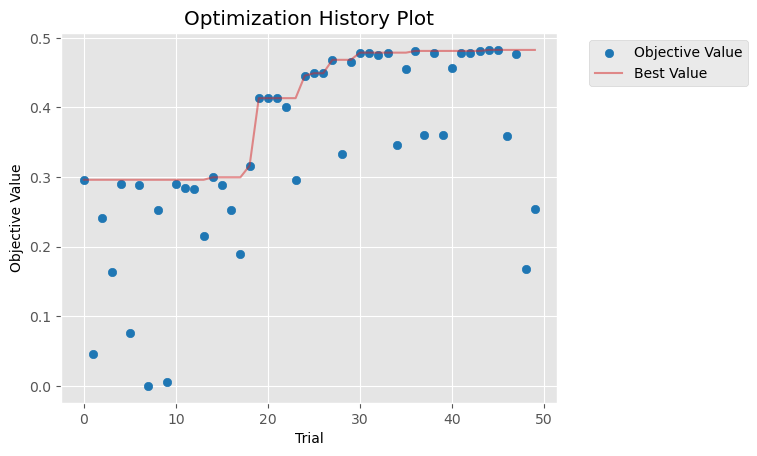

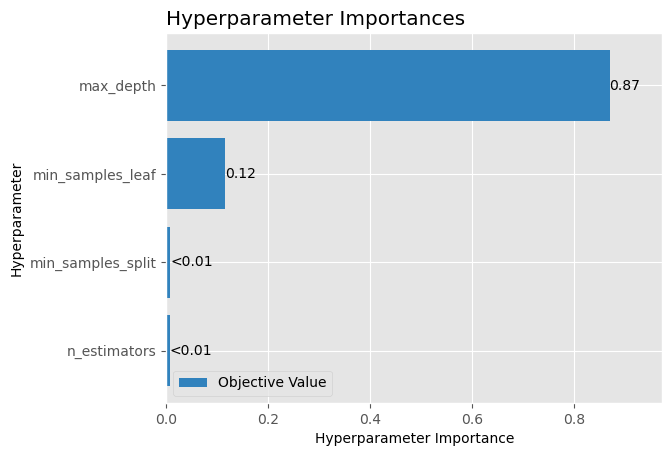

In [108]:
print("Number of finished trials: {}".format(len(study_rf.trials)))

print("Best trial:")
trial = study_rf.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

plot_optimization_history(study_rf)
plot_param_importances(study_rf)

none model accuracy for classification is = 95.62%
------------------------------------------------
Confusion Matrix:
      0    1
0  7714   40
1   323  218
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      7754
           1       0.84      0.40      0.55       541

    accuracy                           0.96      8295
   macro avg       0.90      0.70      0.76      8295
weighted avg       0.95      0.96      0.95      8295



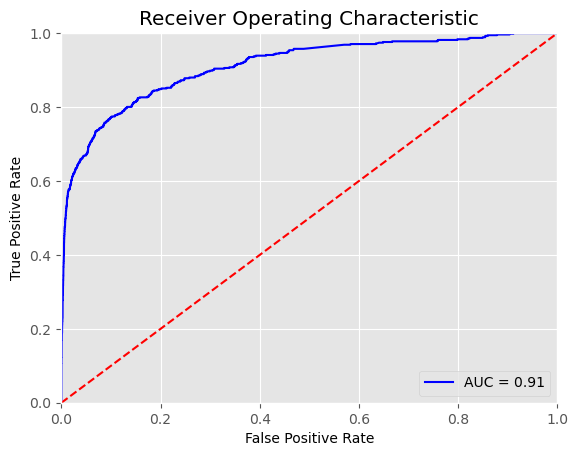

In [109]:
rf_tuned_optuna = RandomForestClassifier(**study_rf.best_trial.params)
rf_tuned_optuna.fit(X_train, y_train)

none model accuracy for classification is = 95.62%
------------------------------------------------
Confusion Matrix:
      0    1
0  7714   40
1   323  218
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      7754
           1       0.84      0.40      0.55       541

    accuracy                           0.96      8295
   macro avg       0.90      0.70      0.76      8295
weighted avg       0.95      0.96      0.95      8295



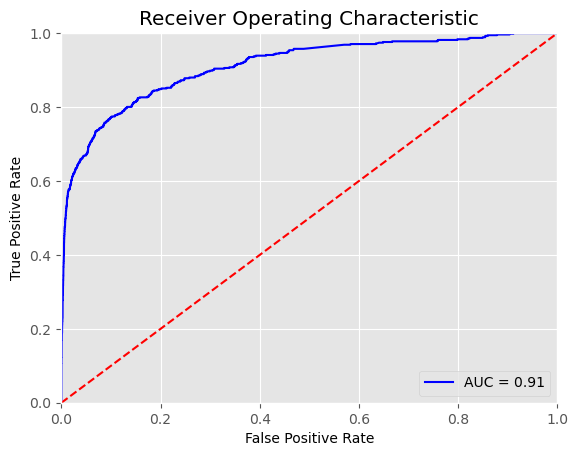

In [165]:
evaluate_model(rf_tuned_optuna, X_test, y_test, "none")
add_to_eval_df(rf_tuned_optuna, "RandomForest-tuned-optuna", "clean", X_train, y_train, X_test, y_test)

##### 2.1.2 BalancedRandomForest untuned

###### BalancedRandomForest no tuning

In [110]:
brf = BalancedRandomForestClassifier(n_jobs=-1)
brf.fit(X_train, y_train)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.u

BalancedRandomForestClassifier(n_jobs=-1)

none model accuracy for classification is = 87.59%
------------------------------------------------
Confusion Matrix:
      0    1
0  6869  885
1   144  397
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.89      0.93      7754
           1       0.31      0.73      0.44       541

    accuracy                           0.88      8295
   macro avg       0.64      0.81      0.68      8295
weighted avg       0.94      0.88      0.90      8295



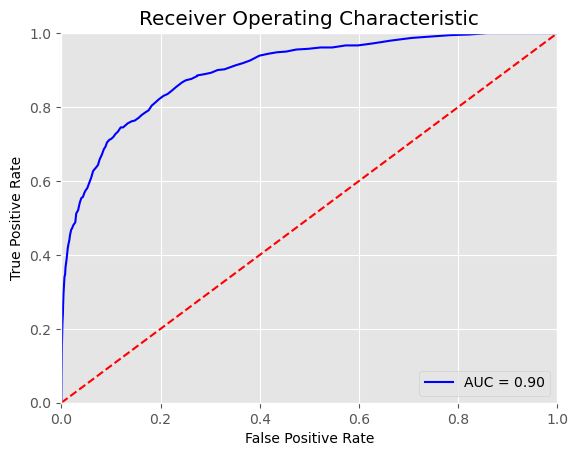

In [166]:
evaluate_model(brf, X_test, y_test, "none")
add_to_eval_df(brf, "BalancedRandomForestClassifier", "clean", X_train, y_train, X_test, y_test)

In [112]:
cv = cross_val_score(brf, X_train, y_train, cv=10, scoring='f1', verbose=10)

[CV] START .....................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV] END ................................ score: (test=0.406) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV] END ................................ score: (test=0.454) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.1s remaining:    0.0s
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV] END ................................ score: (test=0.404) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.1s remaining:    0.0s
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV] END ................................ score: (test=0.439) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    4.0s remaining:    0.0s
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV] END ................................ score: (test=0.428) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.0s remaining:    0.0s
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV] END ................................ score: (test=0.442) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    5.9s remaining:    0.0s
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV] END ................................ score: (test=0.416) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    6.8s remaining:    0.0s
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV] END ................................ score: (test=0.440) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    7.8s remaining:    0.0s
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV] END ................................ score: (test=0.438) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    8.8s remaining:    0.0s
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV] END ................................ score: (test=0.433) total time=   0.8s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    9.7s finished


In [113]:
np.mean(cv)

0.4299422817319094

###### BalancedRandomForest tuning (RandomizedSearchCV)

In [114]:
param_grid = {
    'n_estimators': [100, 150, 200, 250],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [3, 6, 9],
    'max_leaf_nodes': [9, 11, 13],
}

In [115]:
random_search = RandomizedSearchCV(BalancedRandomForestClassifier(n_jobs=-1),
                                   param_grid,
                                   scoring='f1',
                                   verbose=0)
random_search.fit(X_train, y_train)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: 

RandomizedSearchCV(estimator=BalancedRandomForestClassifier(n_jobs=-1),
                   param_distributions={'max_depth': [3, 6, 9],
                                        'max_features': ['sqrt', 'log2', None],
                                        'max_leaf_nodes': [9, 11, 13],
                                        'n_estimators': [100, 150, 200, 250]},
                   scoring='f1')

In [116]:
brf_tuned = BalancedRandomForestClassifier(**random_search.best_params_, verbose=0)
brf_tuned.fit(X_train, y_train)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklear

BalancedRandomForestClassifier(max_depth=6, max_leaf_nodes=13, n_estimators=250)

none model accuracy for classification is = 85.34%
------------------------------------------------
Confusion Matrix:
      0     1
0  6672  1082
1   134   407
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.86      0.92      7754
           1       0.27      0.75      0.40       541

    accuracy                           0.85      8295
   macro avg       0.63      0.81      0.66      8295
weighted avg       0.93      0.85      0.88      8295



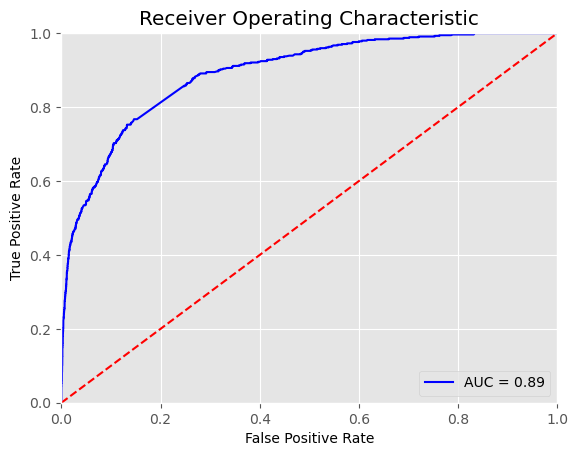

In [167]:
evaluate_model(brf_tuned, X_test, y_test, "none")
add_to_eval_df(brf_tuned, "BalancedRandomForestClassifier-tuned", "clean", X_train, y_train, X_test, y_test)

#### 2.2 Boosting

##### 2.2.1 XGBClassifier

In [118]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

none model accuracy for classification is = 95.15%
------------------------------------------------
Confusion Matrix:
      0    1
0  7711   43
1   359  182
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      7754
           1       0.81      0.34      0.48       541

    accuracy                           0.95      8295
   macro avg       0.88      0.67      0.72      8295
weighted avg       0.95      0.95      0.94      8295



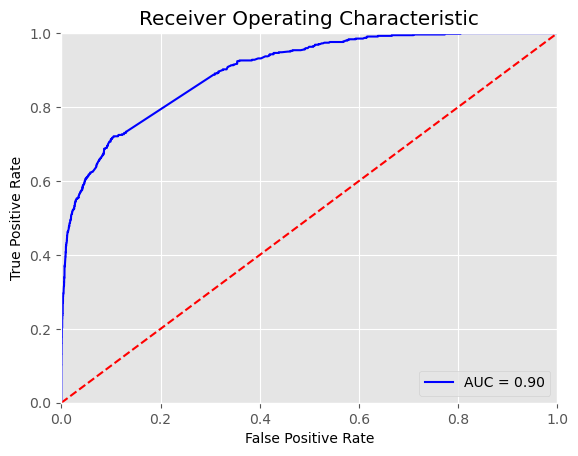

In [168]:
evaluate_model(xgb, X_test, y_test, "none")
add_to_eval_df(xgb, "XGBClassifier", "clean", X_train, y_train, X_test, y_test)

###### XGBClassifier tuning (GridSearchCV)
https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning
https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

Tuning mit GridSearchCV dauert bei großer param-Liste sehr lange, daher einzelne Schritte mit jeweils nur 1 bis max. 2 params

auskommentierte Werte stammen aus TF-IDF GridSearch


In [120]:
param_test = {
    'learning_rate': [0.1, 0.01, 0.001],
}
gsearch = GridSearchCV(estimator=XGBClassifier(
    seed=42
), param_grid=param_test, scoring='f1', n_jobs=-1, cv=5, verbose=1)

# gsearch.fit(X_train, y_train)
# gsearch.best_score_, gsearch.best_params_

# (0.32039688186494825, {'learning_rate': 0.1})

none model accuracy for classification is = 94.94%
------------------------------------------------
Confusion Matrix:
      0    1
0  7735   19
1   401  140
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      7754
           1       0.88      0.26      0.40       541

    accuracy                           0.95      8295
   macro avg       0.92      0.63      0.69      8295
weighted avg       0.95      0.95      0.94      8295



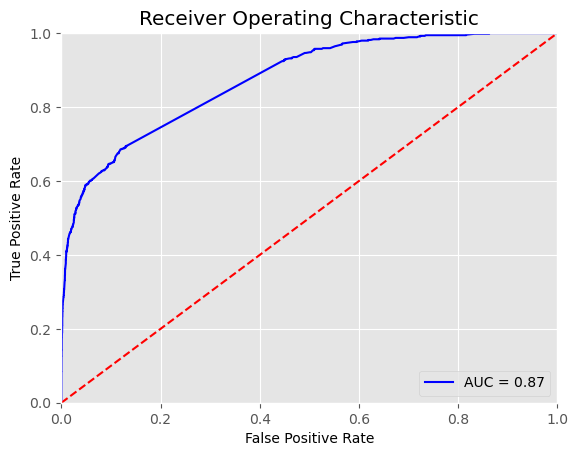

In [121]:
xgb_test = XGBClassifier(learning_rate=0.1)
xgb_test.fit(X_train, y_train)
evaluate_model(xgb_test, X_test, y_test, "none")

In [122]:
param_test = {
    'n_estimators': range(100, 250, 50),
}
gsearch = GridSearchCV(estimator=XGBClassifier(
    seed=42,
    learning_rate=0.1,
), param_grid=param_test, scoring='f1', n_jobs=-1, cv=5, verbose=1)

# gsearch.fit(X_train, y_train)
# gsearch.best_score_, gsearch.best_params_

# (0.37817637241282653, {'n_estimators': 200})

none model accuracy for classification is = 95.12%
------------------------------------------------
Confusion Matrix:
      0    1
0  7723   31
1   374  167
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      7754
           1       0.84      0.31      0.45       541

    accuracy                           0.95      8295
   macro avg       0.90      0.65      0.71      8295
weighted avg       0.95      0.95      0.94      8295



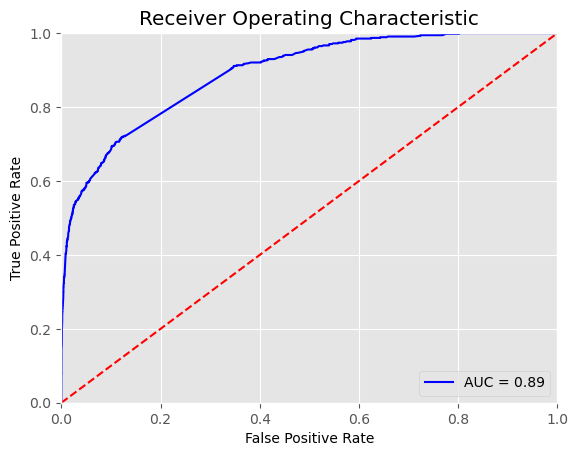

In [123]:
xgb_test = XGBClassifier(learning_rate=0.1, n_estimators=200)
xgb_test.fit(X_train, y_train)
evaluate_model(xgb_test, X_test, y_test, "none")

In [124]:
param_test = {
    'max_depth': range(5, 13, 2),
}
gsearch = GridSearchCV(estimator=XGBClassifier(
    seed=42,
    learning_rate=0.1,
    n_estimators=200,
), param_grid=param_test, scoring='f1', n_jobs=-1, cv=5, verbose=1)

# gsearch.fit(X_train, y_train)
# gsearch.best_score_, gsearch.best_params_

# (0.4298347587940351, {'max_depth': 11})

none model accuracy for classification is = 95.15%
------------------------------------------------
Confusion Matrix:
      0    1
0  7705   49
1   353  188
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      7754
           1       0.79      0.35      0.48       541

    accuracy                           0.95      8295
   macro avg       0.87      0.67      0.73      8295
weighted avg       0.95      0.95      0.94      8295



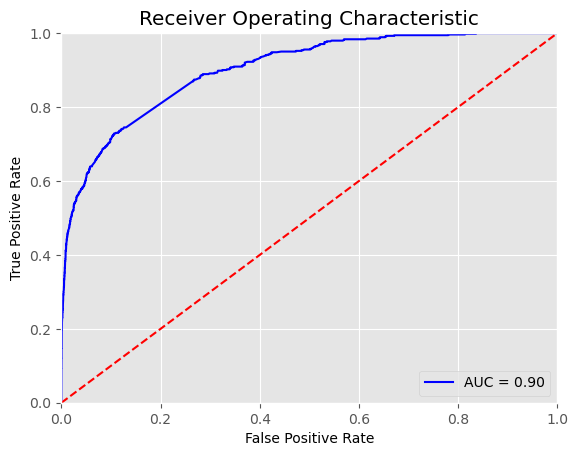

In [125]:
xgb_test = XGBClassifier(learning_rate=0.1, n_estimators=200, max_depth=11)
xgb_test.fit(X_train, y_train)
evaluate_model(xgb_test, X_test, y_test, "none")

In [126]:
param_test = {
    'subsample': [0.5, 0.7, 1]
}
gsearch = GridSearchCV(estimator=XGBClassifier(
    seed=42,
    learning_rate=0.1,
    n_estimators=200,
    max_depth=11,
), param_grid=param_test, scoring='f1', n_jobs=-1, cv=5, verbose=1)

# gsearch.fit(X_train, y_train)
# gsearch.best_score_, gsearch.best_params_

# (0.4406213750099548, {'subsample': 0.7})

none model accuracy for classification is = 95.23%
------------------------------------------------
Confusion Matrix:
      0    1
0  7697   57
1   339  202
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      7754
           1       0.78      0.37      0.51       541

    accuracy                           0.95      8295
   macro avg       0.87      0.68      0.74      8295
weighted avg       0.95      0.95      0.94      8295



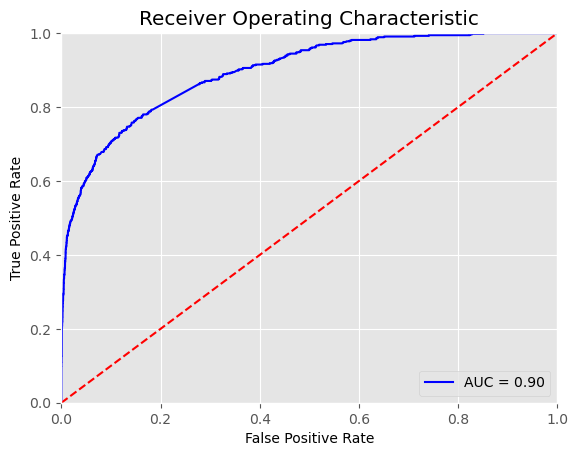

In [127]:
xgb_test = XGBClassifier(learning_rate=0.1, n_estimators=200, max_depth=11, subsample=0.7)
xgb_test.fit(X_train, y_train)
evaluate_model(xgb_test, X_test, y_test, "none")

In [128]:
param_test = {
    'min_child_weight': range(1, 6, 2),
}
gsearch = GridSearchCV(estimator=XGBClassifier(
    seed=42,
    learning_rate=0.1,
    n_estimators=200,
    max_depth=11,
    subsample=0.7,
), param_grid=param_test, scoring='f1', n_jobs=-1, cv=5, verbose=1)

# gsearch.fit(X_train, y_train)
# gsearch.best_score_, gsearch.best_params_

# (0.4406213750099548, {'min_child_weight': 1}) <== kein Einfluss auf Modellperformance

In [129]:
param_test = {
    'gamma': [i / 10.0 for i in range(0, 5)],
}
gsearch = GridSearchCV(estimator=XGBClassifier(
    seed=42,
    learning_rate=0.1,
    n_estimators=200,
    max_depth=11,
    subsample=0.7,
), param_grid=param_test, scoring='f1', n_jobs=-1, cv=5, verbose=1)

# gsearch.fit(X_train, y_train)
# gsearch.best_score_, gsearch.best_params_

# (0.4406213750099548, {'gamma': 0.0}) <== kein Einfluss auf Modellperformance

In [130]:
param_test = {
    'reg_alpha': [1e-5, 1e-2, 0.1, 1, 100]
}
gsearch = GridSearchCV(estimator=XGBClassifier(
    seed=42,
    learning_rate=0.1,
    n_estimators=200,
    max_depth=11,
    subsample=0.7,
), param_grid=param_test, scoring='f1', n_jobs=-1, cv=5, verbose=1)

gsearch.fit(X_train, y_train)
gsearch.best_score_, gsearch.best_params_

# (0.44114103318625436, {'reg_alpha': 0.01})

Fitting 5 folds for each of 5 candidates, totalling 25 fits


(0.45847166439065046, {'reg_alpha': 0.01})

In [131]:
param_test = {
    'reg_alpha': [0.005, 0.01, 0.015, 0.02, 0.025]
}
gsearch = GridSearchCV(estimator=XGBClassifier(
    seed=42,
    learning_rate=0.1,
    n_estimators=200,
    max_depth=11,
    subsample=0.7,
), param_grid=param_test, scoring='f1', n_jobs=-1, cv=5, verbose=1)

gsearch.fit(X_train, y_train)
gsearch.best_score_, gsearch.best_params_

# # (0.44114103318625436, {'reg_alpha': 0.01})

Fitting 5 folds for each of 5 candidates, totalling 25 fits


(0.45847166439065046, {'reg_alpha': 0.01})

In [132]:
xgb_tuned_grid = XGBClassifier(learning_rate=0.1, n_estimators=200, max_depth=11, subsample=0.7, reg_alpha=0.01)
xgb_tuned_grid.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=11, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

none model accuracy for classification is = 95.24%
------------------------------------------------
Confusion Matrix:
      0    1
0  7702   52
1   343  198
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      7754
           1       0.79      0.37      0.50       541

    accuracy                           0.95      8295
   macro avg       0.87      0.68      0.74      8295
weighted avg       0.95      0.95      0.94      8295



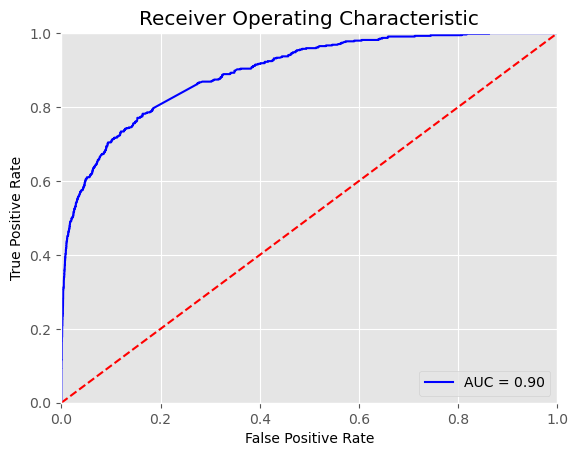

In [169]:
evaluate_model(xgb_tuned_grid, X_test, y_test, "none")
add_to_eval_df(xgb_tuned_grid, "XGBClassifier-tuned-grid", "clean", X_train, y_train, X_test, y_test)

###### XGBClassifier tuning (RandomizedSearchCV)
Vergleich Modellperformance zwischen GridSearchCV <-> RandomizedSearchCV

In [134]:
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': range(100, 250, 50),
    'max_depth': range(5, 13, 2),
    'subsample': [0.5, 0.7, 1],
    'min_child_weight': range(1, 6, 2),
    'gamma': [i / 10.0 for i in range(0, 5)],
    'reg_alpha': [1e-5, 1e-2, 0.1, 1, 100],
}

In [135]:
rsearch = RandomizedSearchCV(XGBClassifier(n_jobs=-1),
                             param_grid,
                             scoring='f1',
                             verbose=1,
                             cv=5,
                             )

In [136]:
rsearch.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=-1,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   param_distributions={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.1, 0.01, 0.001],
                                        'max_depth': range(5, 13, 2),
                                        'min_child_weight': range(1, 6, 2),
                                        'n_estimators': range(100, 250, 50),
                                        'reg_alpha': [1e-05, 0.01, 0.1, 1, 100],
                                        'subsample': [0.5, 0.7, 1]},
                   scoring='f1', verbose=1)

In [137]:
rsearch.best_score_, rsearch.best_params_

(0.2553358344611475,
 {'subsample': 0.5,
  'reg_alpha': 1e-05,
  'n_estimators': 200,
  'min_child_weight': 5,
  'max_depth': 7,
  'learning_rate': 0.1,
  'gamma': 0.2})

In [138]:
xgb_tuned_rand = XGBClassifier(**rsearch.best_params_, n_jobs=-1)
xgb_tuned_rand.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

none model accuracy for classification is = 94.09%
------------------------------------------------
Confusion Matrix:
      0   1
0  7707  47
1   443  98
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      7754
           1       0.68      0.18      0.29       541

    accuracy                           0.94      8295
   macro avg       0.81      0.59      0.63      8295
weighted avg       0.93      0.94      0.92      8295



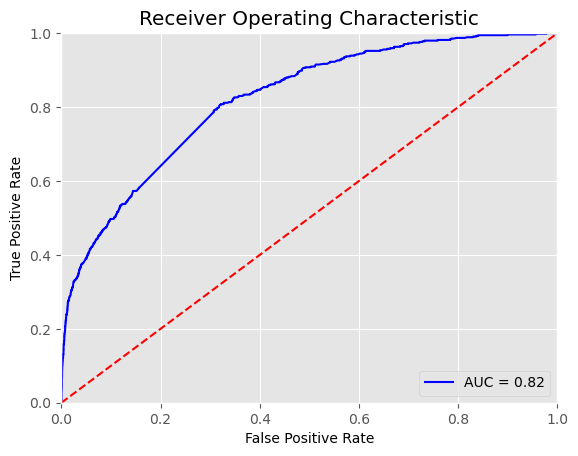

In [170]:
evaluate_model(xgb_tuned_rand, X_test, y_test, "none")
add_to_eval_df(xgb_tuned_rand, "XGBClassifier-tuned-rand", "clean", X_train, y_train, X_test, y_test)

###### XGBClassifier tuning (optuna)
https://randomrealizations.com/posts/xgboost-parameter-tuning-with-optuna/
https://www.kaggle.com/code/rzatemizel/optuna-xgboostcv-integration-with-pruning#Intro

In [158]:
def balancedlogloss(predt: np.ndarray, dtrain: xgboost.DMatrix) -> Tuple[str, float]:
    ''' balanced log loss metric.'''
    y = dtrain.get_label()
    target_mean = y.mean()
    w0 = 1 / (1 - target_mean)
    w1 = 1 / target_mean
    sample_weight = [w0 if y == 0 else w1 for y in y]
    loss = log_loss(y, predt, eps=1e-15, sample_weight=sample_weight)

    return 'balancedlogloss', loss

def objective(trial):
    dtrain = xgboost.DMatrix(X_train, label=y_train)

    param = {

        "verbosity": 0,
        "objective": "binary:logistic",
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        "subsample": trial.suggest_float("subsample", 0.2, 0.8),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 0.8),
        'scale_pos_weight': 509 / 108,
        'random_state': 42,
    }

    if param["booster"] == "gbtree" or param["booster"] == "dart":
        param["max_depth"] = trial.suggest_int("max_depth", 1, 16)
        param["eta"] = trial.suggest_float("eta", 1e-3, 1.0, log=True)
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "test-balancedlogloss")
    history = xgboost.cv(param,
                     dtrain,
                     stratified=True,
                     nfold=5,
                     num_boost_round=10000,
                     early_stopping_rounds=50,
                     custom_metric=balancedlogloss,
                     seed=42,
                     callbacks=[pruning_callback])

    mean_balancedlogloss = history["test-balancedlogloss-mean"].values[-1]
    trial.set_user_attr("n_estimators", len(history))
    return mean_balancedlogloss


In [159]:
sampler = TPESampler(seed=42)
pruner = optuna.pruners.MedianPruner(n_warmup_steps=10)
study = optuna.create_study(sampler=sampler, pruner=pruner, direction="minimize")
study.optimize(objective, n_trials=5)

[I 2024-11-24 19:31:05,786] A new study created in memory with name: no-name-5e5ad6a6-a6ed-440e-8aaa-8b6ba08d91f8
[I 2024-11-24 19:31:45,271] Trial 0 finished with value: 0.4852012 and parameters: {'booster': 'gblinear', 'lambda': 0.0006155564318973012, 'alpha': 1.77071686435378e-07, 'subsample': 0.2935967122017216, 'colsample_bytree': 0.23485016730091968}. Best is trial 0 with value: 0.4852012.
[I 2024-11-24 20:37:48,104] Trial 1 finished with value: 0.5362128 and parameters: {'booster': 'gbtree', 'lambda': 1.4610865886287176e-08, 'alpha': 0.574485163632042, 'subsample': 0.6994655844802531, 'colsample_bytree': 0.3274034664069657, 'max_depth': 3, 'eta': 0.0035498788321965025, 'gamma': 2.716051144654844e-06, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.4852012.
[I 2024-11-24 20:38:06,484] Trial 2 finished with value: 0.48188339999999996 and parameters: {'booster': 'gblinear', 'lambda': 2.1734877073417355e-06, 'alpha': 8.528933855762793e-06, 'subsample': 0.4736419905302216,

Number of finished trials: 5
Best trial:
  Value: 0.48188339999999996
  Params: 
    booster: gblinear
    lambda: 2.1734877073417355e-06
    alpha: 8.528933855762793e-06
    subsample: 0.4736419905302216
    colsample_bytree: 0.6711055768358083


C:\Users\admin\AppData\Local\Temp\ipykernel_18300\993762437.py:13: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study)
C:\Users\admin\AppData\Local\Temp\ipykernel_18300\993762437.py:14: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

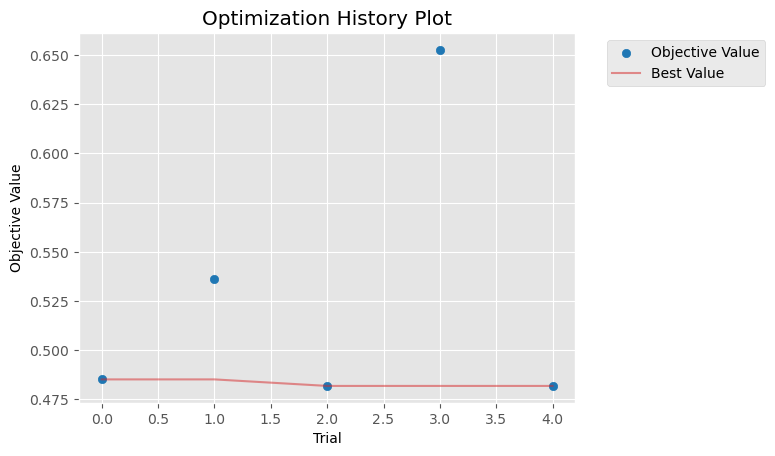

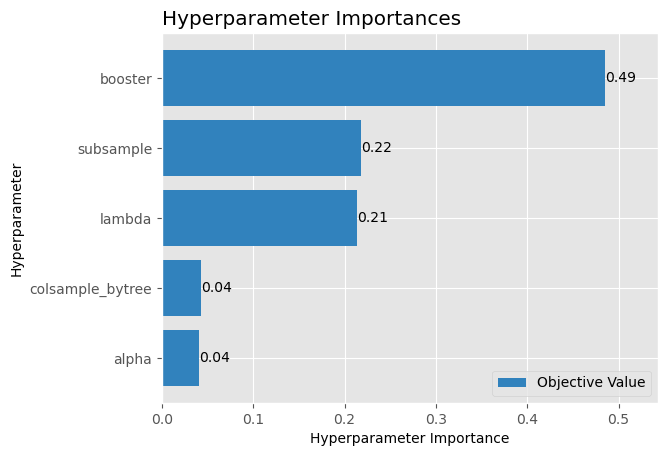

In [160]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# print("  Number of estimators: {}".format(trial.user_attrs["n_estimators"]))

plot_optimization_history(study)
plot_param_importances(study)

none model accuracy for classification is = 95.32%
------------------------------------------------
Confusion Matrix:
      0    1
0  7630  124
1   264  277
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      7754
           1       0.69      0.51      0.59       541

    accuracy                           0.95      8295
   macro avg       0.83      0.75      0.78      8295
weighted avg       0.95      0.95      0.95      8295



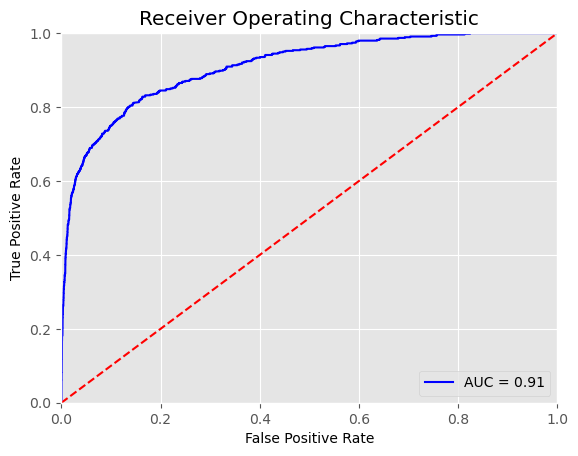

ValueError: cannot set a row with mismatched columns

In [161]:
xgb_tuned_optuna = XGBClassifier(**study.best_trial.params)
xgb_tuned_optuna.fit(X_train, y_train)

none model accuracy for classification is = 95.32%
------------------------------------------------
Confusion Matrix:
      0    1
0  7630  124
1   264  277
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      7754
           1       0.69      0.51      0.59       541

    accuracy                           0.95      8295
   macro avg       0.83      0.75      0.78      8295
weighted avg       0.95      0.95      0.95      8295



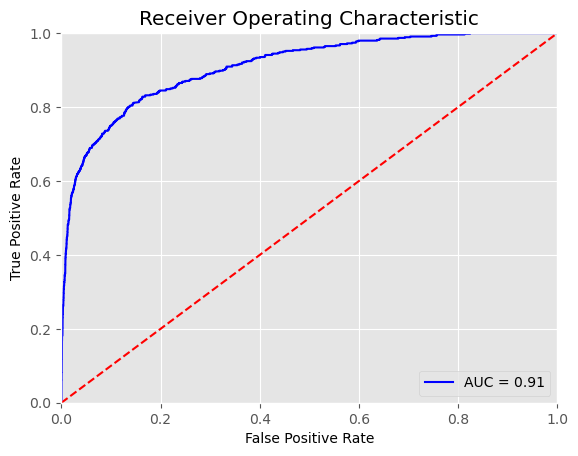

In [171]:
evaluate_model(xgb_tuned_optuna, X_test, y_test, "none")
add_to_eval_df(xgb_tuned_optuna, "XGBClassifier-tuned-optuna", "clean", X_train, y_train, X_test, y_test)

##### 2.2.1 CatBoostClassifier

In [142]:
cat = CatBoostClassifier(iterations=100,
                         depth=5,
                         learning_rate=0.1,
                         loss_function='Logloss',
                         verbose=True)
cat.fit(X_train, y_train)

0:	learn: 0.5864107	total: 24.2ms	remaining: 2.4s
1:	learn: 0.5053324	total: 46.8ms	remaining: 2.29s
2:	learn: 0.4435850	total: 69.9ms	remaining: 2.26s
3:	learn: 0.3944336	total: 90.6ms	remaining: 2.17s
4:	learn: 0.3551596	total: 114ms	remaining: 2.16s
5:	learn: 0.3255034	total: 136ms	remaining: 2.13s
6:	learn: 0.3012804	total: 159ms	remaining: 2.11s
7:	learn: 0.2834424	total: 182ms	remaining: 2.09s
8:	learn: 0.2685149	total: 205ms	remaining: 2.07s
9:	learn: 0.2561130	total: 227ms	remaining: 2.04s
10:	learn: 0.2463394	total: 250ms	remaining: 2.02s
11:	learn: 0.2378599	total: 271ms	remaining: 1.99s
12:	learn: 0.2318283	total: 295ms	remaining: 1.97s
13:	learn: 0.2265216	total: 319ms	remaining: 1.96s
14:	learn: 0.2225085	total: 342ms	remaining: 1.94s
15:	learn: 0.2189921	total: 365ms	remaining: 1.92s
16:	learn: 0.2156051	total: 388ms	remaining: 1.89s
17:	learn: 0.2131473	total: 411ms	remaining: 1.87s
18:	learn: 0.2110565	total: 434ms	remaining: 1.85s
19:	learn: 0.2089937	total: 457ms	rema

none model accuracy for classification is = 94.66%
------------------------------------------------
Confusion Matrix:
      0    1
0  7738   16
1   427  114
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      7754
           1       0.88      0.21      0.34       541

    accuracy                           0.95      8295
   macro avg       0.91      0.60      0.66      8295
weighted avg       0.94      0.95      0.93      8295



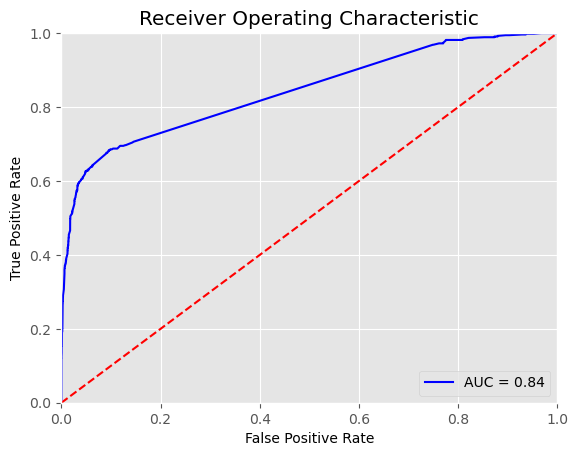

In [172]:
evaluate_model(cat, X_test, y_test, "none")
add_to_eval_df(cat, "CatBoostClassifier", "clean", X_train, y_train, X_test, y_test)

##### 2.2.1 LGBMClassifier

In [144]:
light = LGBMClassifier()
light.fit(X_train, y_train)

TypeError: Expected np.float32 or np.float64, met type(int64)

In [173]:
evaluate_model(light, X_test, y_test, "none")
add_to_eval_df(light, "LGBMClassifier", "clean", X_train, y_train, X_test, y_test)

NotFittedError: Estimator not fitted, call fit before exploiting the model.

#### 2.3 Stacking

##### 2.3.1 Stacking: RandomForest + LinearSVC

In [145]:
base_models = [
    ('rf', RandomForestClassifier(random_state=42)),
    ('svc', LinearSVC(random_state=42))
]
stack = StackingClassifier(estimators=base_models, n_jobs=-1)

In [146]:
stack.fit(X_train, y_train)

StackingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                               ('svc', LinearSVC(random_state=42))],
                   n_jobs=-1)

none model accuracy for classification is = 95.88%
------------------------------------------------
Confusion Matrix:
      0    1
0  7677   77
1   265  276
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      7754
           1       0.78      0.51      0.62       541

    accuracy                           0.96      8295
   macro avg       0.87      0.75      0.80      8295
weighted avg       0.95      0.96      0.95      8295



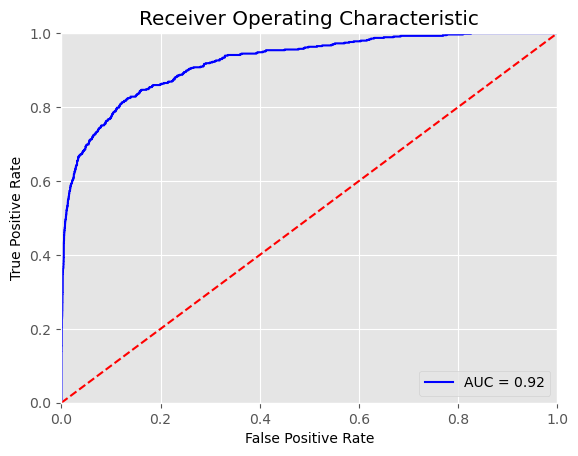

In [174]:
evaluate_model(stack, X_test, y_test, "none")
add_to_eval_df(stack, "StackingClassifier", "clean", X_train, y_train, X_test, y_test)

Vergleich: SVC

In [148]:
svc = LinearSVC()
svc.fit(X_train, y_train)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()

In [175]:
evaluate_model(svc, X_test, y_test, "none")
add_to_eval_df(svc, "LinearSVC", "clean", X_train, y_train, X_test, y_test)

none model accuracy for classification is = 95.12%
------------------------------------------------
Confusion Matrix:
      0    1
0  7601  153
1   252  289
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      7754
           1       0.65      0.53      0.59       541

    accuracy                           0.95      8295
   macro avg       0.81      0.76      0.78      8295
weighted avg       0.95      0.95      0.95      8295



AttributeError: 'LinearSVC' object has no attribute 'predict_proba'

#### Model comparision

In [176]:
evaluation.sort_values(by=["test_prec"], ascending=False)

,model,variant,train_acc,train_prec,train_rec,train_f1,test_acc,test_prec,test_rec,test_f1
9,CatBoostClassifier,clean,0.947039,0.893891,0.218898,0.351676,0.946594,0.876923,0.210721,0.339791
2,RandomForest-tuned-optuna,clean,0.978196,1.000000,0.667717,0.800755,0.956239,0.844961,0.402957,0.545682
5,XGBClassifier,clean,0.956805,0.894545,0.387402,0.540659,0.951537,0.808889,0.336414,0.475196
6,XGBClassifier-tuned-grid,clean,0.958200,0.876020,0.422835,0.570366,0.952381,0.792000,0.365989,0.500632
10,StackingClassifier,clean,0.998708,1.000000,0.980315,0.990060,0.958770,0.781870,0.510166,0.617450
1,RandomForestClassifier-tuned-rand,clean,0.939857,0.778947,0.116535,0.202740,0.940205,0.764706,0.120148,0.207668
0,RandomForestClassifier,clean,0.999948,1.000000,0.999213,0.999606,0.955274,0.759146,0.460259,0.573072
8,XGBClassifier-tuned-optuna,clean,0.990648,0.989218,0.866929,0.924045,0.953225,0.690773,0.512015,0.588110
7,XGBClassifier-tuned-rand,clean,0.941149,0.695522,0.183465,0.290343,0.940928,0.675862,0.181146,0.285714
3,BalancedRandomForestClassifier,clean,0.897541,0.390409,1.000000,0.561574,0.875949,0.309672,0.733826,0.435546


In [177]:
evaluation.sort_values(by=["test_rec"], ascending=False)

,model,variant,train_acc,train_prec,train_rec,train_f1,test_acc,test_prec,test_rec,test_f1
4,BalancedRandomForestClassifier-tuned,clean,0.856670,0.289709,0.815748,0.427569,0.853406,0.273338,0.752311,0.400985
3,BalancedRandomForestClassifier,clean,0.897541,0.390409,1.000000,0.561574,0.875949,0.309672,0.733826,0.435546
8,XGBClassifier-tuned-optuna,clean,0.990648,0.989218,0.866929,0.924045,0.953225,0.690773,0.512015,0.588110
10,StackingClassifier,clean,0.998708,1.000000,0.980315,0.990060,0.958770,0.781870,0.510166,0.617450
0,RandomForestClassifier,clean,0.999948,1.000000,0.999213,0.999606,0.955274,0.759146,0.460259,0.573072
2,RandomForest-tuned-optuna,clean,0.978196,1.000000,0.667717,0.800755,0.956239,0.844961,0.402957,0.545682
6,XGBClassifier-tuned-grid,clean,0.958200,0.876020,0.422835,0.570366,0.952381,0.792000,0.365989,0.500632
5,XGBClassifier,clean,0.956805,0.894545,0.387402,0.540659,0.951537,0.808889,0.336414,0.475196
9,CatBoostClassifier,clean,0.947039,0.893891,0.218898,0.351676,0.946594,0.876923,0.210721,0.339791
7,XGBClassifier-tuned-rand,clean,0.941149,0.695522,0.183465,0.290343,0.940928,0.675862,0.181146,0.285714


In [178]:
evaluation.sort_values(by=["test_f1"], ascending=False)

,model,variant,train_acc,train_prec,train_rec,train_f1,test_acc,test_prec,test_rec,test_f1
10,StackingClassifier,clean,0.998708,1.000000,0.980315,0.990060,0.958770,0.781870,0.510166,0.617450
8,XGBClassifier-tuned-optuna,clean,0.990648,0.989218,0.866929,0.924045,0.953225,0.690773,0.512015,0.588110
0,RandomForestClassifier,clean,0.999948,1.000000,0.999213,0.999606,0.955274,0.759146,0.460259,0.573072
2,RandomForest-tuned-optuna,clean,0.978196,1.000000,0.667717,0.800755,0.956239,0.844961,0.402957,0.545682
6,XGBClassifier-tuned-grid,clean,0.958200,0.876020,0.422835,0.570366,0.952381,0.792000,0.365989,0.500632
5,XGBClassifier,clean,0.956805,0.894545,0.387402,0.540659,0.951537,0.808889,0.336414,0.475196
3,BalancedRandomForestClassifier,clean,0.897541,0.390409,1.000000,0.561574,0.875949,0.309672,0.733826,0.435546
4,BalancedRandomForestClassifier-tuned,clean,0.856670,0.289709,0.815748,0.427569,0.853406,0.273338,0.752311,0.400985
9,CatBoostClassifier,clean,0.947039,0.893891,0.218898,0.351676,0.946594,0.876923,0.210721,0.339791
7,XGBClassifier-tuned-rand,clean,0.941149,0.695522,0.183465,0.290343,0.940928,0.675862,0.181146,0.285714


In [179]:
evaluation['vectorize_variant'] = "bow"
evaluation = evaluation[['model',
 'variant',
 'vectorize_variant',
 'train_acc',
 'train_prec',
 'train_rec',
 'train_f1',
 'test_acc',
 'test_prec',
 'test_rec',
 'test_f1']]

outname = 'evaluation_bow.csv'

outdir = './eval_data'
if not os.path.exists(outdir):
    os.mkdir(outdir)

fullname = os.path.join(outdir, outname)

evaluation.to_csv(fullname)